# Arbol de Decisión
Un árbol de decisión es un modelo de aprendizaje automático que toma decisiones basadas en una serie de preguntas (nodos) para clasificar o predecir datos. Cada pregunta divide los datos en ramas, lo que lleva a decisiones finales (hojas) que representan las predicciones. Es una técnica de aprendizaje supervisado utilizada en clasificación y regresión.
Exportamos el DataFrame ya trabajado anteriormente.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trata_exp = pd.read_csv('../trata_exp.csv') 
trata_exp.shape

(5741, 13)

### Adecuaciones para trabajar en el modelo

#### Filtrado de Sexo y Edad

Se eliminan las filas del Sexo "Desconocido" (Unknown) y "Otros" (Others) que representan el 10.9% del total.

In [2]:
df = trata_exp.copy()
df = df[df['Sex'] != 'Unknown']
df = df[df['Sex'] != 'Other']
df = df[df['Age'] != 'Unknown']
df.shape

(5118, 13)

### Valores extremos (outliner)
Se procede a eliminar los valors extremos.

In [3]:
# Calcula el rango intercuartil (IQR)
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1

# Define los límites para identificar valores atípicos 2 veces el rango intercuartil
limite_inferior = Q1 - 2 * IQR
limite_superior = Q3 + 2 * IQR

# Crea una máscara booleana para identificar las filas con valores atípicos.
mascara_atipicos = (df['Value'] < limite_inferior) | (df['Value'] > limite_superior)

# Filtra el DataFrame para eliminar las filas con valores atípicos
df_sin_atipicos = df[~mascara_atipicos]
# Se crea una copia para evitar dataframes rebanados (slices)
df_arbol = df_sin_atipicos.copy()


Se crean las etiquetas para las variables categóricas: Categoría, Sexo y Edad.

In [4]:
from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder para cada variable categórica
label_encoder_category = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_age = LabelEncoder()

# Aplicar LabelEncoder a cada variable categórica
df_arbol['Category_encoded'] = label_encoder_category.fit_transform(df_arbol['Category'])
df_arbol['Sex_encoded'] = label_encoder_sex.fit_transform(df_arbol['Sex'])
df_arbol['Age_encoded'] = label_encoder_age.fit_transform(df_arbol['Age'])

nuevo_orden = ['Category_encoded','Age_encoded', 'Sex_encoded' ]
df_arbol = df_arbol[nuevo_orden]
df_arbol.sample(15)

,Category_encoded,Age_encoded,Sex_encoded
4751,1,1,1
3471,0,1,0
2365,0,1,1
2539,0,1,0
2884,0,1,0
198,2,1,0
5111,1,1,0
3016,2,0,1
3611,0,1,0
4898,1,0,0


Las codificación de las categorías son: *CATEGORÍA: 0 EXP. POR FUERZA LABORAL, 1 EXP. SEXUAL Y 2 OTRAS FORMAS DE EXPLOTACIÓN, - EDAD: 0 MENOR DE 18 AÑOS, 1 MAYOR DE 18 AÑOS, - SEXO: 0 FEMENINO, 1 MASCULINO*

## Entrenamiento del modelo.
Se intenta explicar la categoría del delito (variable y) por las categorias sexo y edad (variables x).
Se entrena bajo el criterio de Entropía y se imprime el número de precisión.

In [9]:
from sklearn.tree import DecisionTreeClassifier
y = df_arbol.iloc[:,0]
x = df_arbol.iloc[:,1:]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


arbol = DecisionTreeClassifier(criterion='entropy', max_depth=5)
arbol.fit(x_train, y_train)
prediccion = arbol.predict(x_test)

from sklearn.metrics import accuracy_score
print(f'La precisión del modelo es: {accuracy_score(y_test, prediccion)}')



La precisión del modelo es: 0.3475258918296893


### Métricas del módelo

Usamos la precisión para analizar los datos obtenidos.

In [10]:
from sklearn import tree
print(tree.export_text(arbol, feature_names=['Age', 'Sex'], class_names=['Forced labour', 'Sexual exploitation', 'Other forms of exploitation']))

|--- Sex <= 0.50
|   |--- Age <= 0.50
|   |   |--- class: Forced labour
|   |--- Age >  0.50
|   |   |--- class: Forced labour
|--- Sex >  0.50
|   |--- Age <= 0.50
|   |   |--- class: Other forms of exploitation
|   |--- Age >  0.50
|   |   |--- class: Other forms of exploitation



Se verifica la cantidad de clases: 3, que son las categorias de violencia.

In [6]:
num_clases = len(arbol.classes_)
print(f'Número de clases: {num_clases}')

Número de clases: 3


Se importa el gráfico del árbol en PDF (arbol.pdf).

In [15]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(arbol, out_file=None, feature_names=['Age', 'Sex'], class_names=['Forced labour', 'Sexual exploitation', 'Other forms of exploitation'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("arbol")  # Esto creará un archivo "arbol.pdf" en el directorio actual
graph.view("arbol")    # Esto abrirá la representación gráfica del árbol en un visor PDF

'arbol.pdf'

Se prueba bajo el criterio del coeficiente de Gini si es posible mejorar la predición. De todas formas la precisión es similar.

In [14]:
from sklearn.tree import DecisionTreeClassifier
y = df_arbol.iloc[:,0]
x = df_arbol.iloc[:,1:]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


arbol_gini = DecisionTreeClassifier(criterion='gini', max_depth=5)
arbol_gini.fit(x_train, y_train)
prediccion = arbol_gini.predict(x_test)

from sklearn.metrics import accuracy_score
print(f'La precisión del modelo es: {accuracy_score(y_test, prediccion)}')
from sklearn import tree
print(tree.export_text(arbol_gini, feature_names=['Age', 'Sex'], class_names=['Forced labour', 'Sexual exploitation', 'Other forms of exploitation']))

La precisión del modelo es: 0.3233601841196778
|--- Sex <= 0.50
|   |--- Age <= 0.50
|   |   |--- class: Forced labour
|   |--- Age >  0.50
|   |   |--- class: Sexual exploitation
|--- Sex >  0.50
|   |--- Age <= 0.50
|   |   |--- class: Other forms of exploitation
|   |--- Age >  0.50
|   |   |--- class: Other forms of exploitation



Se imprime el gráfico de arbol (arbol2.pdf).

In [16]:

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(arbol_gini, out_file=None, feature_names=['Age', 'Sex'], class_names=['Forced labour', 'Sexual exploitation', 'Other forms of exploitation'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("arbol2")  # Esto creará un archivo "arbol.pdf" en el directorio actual
graph.view("arbol2")    # Esto abrirá la representación gráfica del árbol en un visor PDF

'arbol2.pdf'

Analizamos la cantidad de paths o números de ruta y graficamos. Criterio entropía.

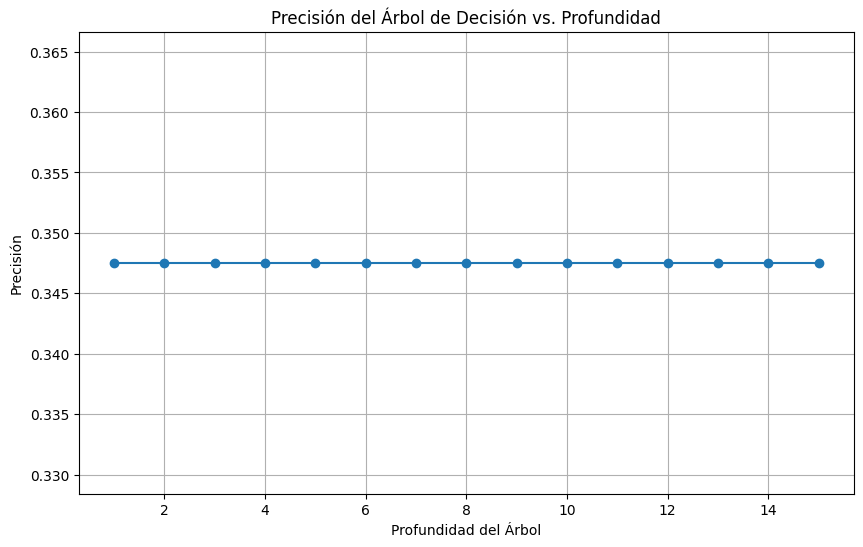

In [13]:
depths = range(1, 16)  # Por ejemplo, exploraremos profundidades de 1 a 15.
precisiones = []

for depth in depths:
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precisiones.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(depths, precisiones, marker='o', linestyle='-')
plt.title('Precisión del Árbol de Decisión vs. Profundidad')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

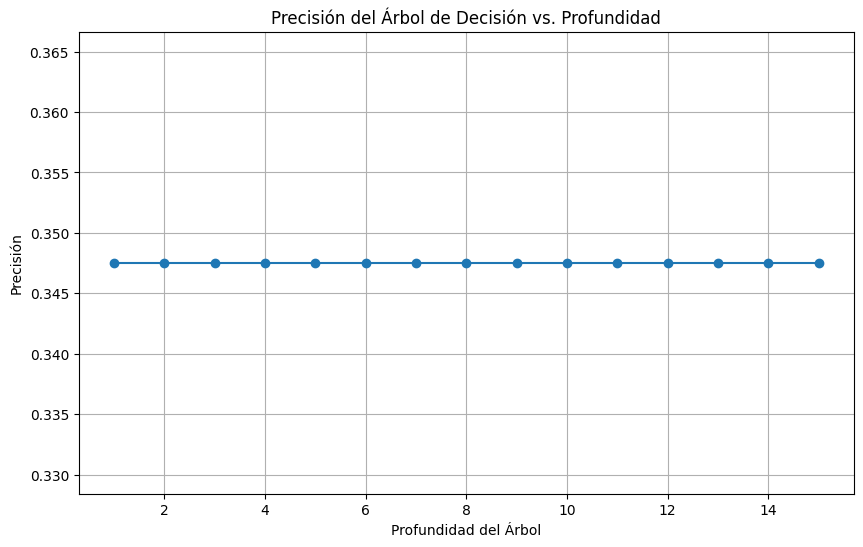

In [14]:
depths = range(1, 16)  # Por ejemplo, exploraremos profundidades de 1 a 15.
precisiones2 = []

for depth in depths:
    model2 = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    model2.fit(x_train, y_train)
    y_pred2 = model2.predict(x_test)
    accuracy2 = accuracy_score(y_test, y_pred)
    precisiones2.append(accuracy2)

plt.figure(figsize=(10, 6))
plt.plot(depths, precisiones2, marker='o', linestyle='-')
plt.title('Precisión del Árbol de Decisión vs. Profundidad')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

Podemos decir que no hay cambios significativos, dado que tampoco hay tantas variables a analizar.

#### Conclusión Breve
Del árbol de decisión se puede clasificar que las mujeres menores corren más riesgo de sufrir explotación laboral, en el caso de mayores de edad explotación sexual (entropía). Igual situación para lo analizado bajo Gini. En el caso de los varones menores se clasifica como explotación laboral y para mayores en otras formas de explotación por entropía. Igual consideración para Gini.
En ambos casos la precisión no es la esperada por lo que deberá trabajarse con los obtenidos.